In [2]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [20]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

In [21]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)
print(gF.shape)
print(data_ext.shape)

(435,)
(268, 268, 435)


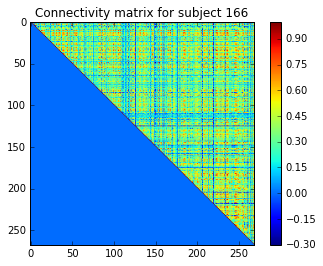

In [22]:
# choose dataset
conn_mats = data['rest_1_mat']
#conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

In [26]:
# PCA (all edges)

pca = PCA(n_components=0.999)
data_pc = pca.fit_transform(edges)
print('No. of components:',pca.n_components_)

No. of components: 114
(115, 114)


In [ ]:
# Test with all edges (PCA on all data)
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
estimator = RandomForestRegressor(random_state=0, n_estimators=100, oob_score=True)

# PCA (all edges)

pca = PCA(n_components=0.999)
data_pc = pca.fit_transform(edges)

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    # regression
    estimator.fit(data_pc[train_index,],gF[train_index])
    predictions[i] = estimator.predict(data_pc[test_index,])

    errors[i] = abs(predictions[i]-gF[test_index])
    i += 1
    f.value += 1
        
print('Mean error:',errors.mean())
preds_1 = predictions;

In [39]:
# Test with all edges (PCA in CV)
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
estimator = RandomForestRegressor(random_state=0, n_estimators=100, oob_score=True)
pca = PCA(n_components=0.999)

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    # decomposition
    data_pc = pca.fit_transform(edges[train_index,])
    # regression
    estimator.fit(data_pc,gF[train_index])
    predictions[i] = estimator.predict(pca.transform(edges[test_index,]))

    errors[i] = abs(predictions[i]-gF[test_index])
    i += 1
    f.value += 1
        
print('Mean error:',errors.mean())
preds_2 = predictions


Mean error: 3.74930434783


In [43]:
# Test with two distinct model for positive and negative edges (PCA on training data)


loo = cross_validation.LeaveOneOut(n_subj)
errors_pos = np.zeros([n_subj,1])
errors_neg = np.zeros([n_subj,1])
predictions_pos = np.zeros([n_subj,1])
predictions_neg = np.zeros([n_subj,1])
estimator = RandomForestRegressor(random_state=0, n_estimators=100, oob_score=True)
pca = PCA(n_components=0.999)



def regress(p,score,edges):
    i=0
    f = FloatProgress(min=0, max=n_subj)
    display(f)
    for train_index, test_index in loo:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # decomposition & regression 
        pc_pos = pca.fit_transform(filtered_pos)
        estimator.fit(pc_pos,gF[train_index])
        predictions_pos[i] = estimator.predict(pca.transform(edges[np.ix_(test_index,idx_filtered_pos)]))
        pc_neg = pca.fit_transform(filtered_neg)
        estimator.fit(pc_neg,gF[train_index])
        predictions_neg[i] = estimator.predict(pca.transform(edges[np.ix_(test_index,idx_filtered_neg)]))
        errors_pos[i] = abs(predictions_pos[i]-gF[test_index])
        errors_neg[i] = abs(predictions_neg[i]-gF[test_index])
        i=i+1
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges))
p = 0.01
regress(p,gF,edges)
preds_3 = predictions_pos
preds_4 = predictions_neg


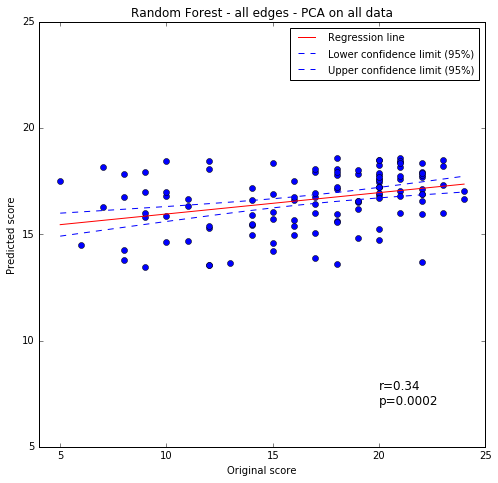

In [38]:

def regression_plot(x,y,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n_subj - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    
    
regression_plot(np.ravel(gF),np.ravel(preds_1),'Random Forest - LOOCV - all edges - PCA on all data')    

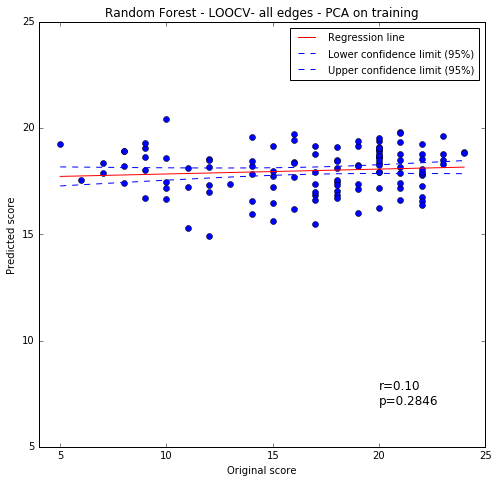

In [42]:
regression_plot(np.ravel(gF),np.ravel(preds_2),'Random Forest - LOOCV- all edges - PCA on training') 

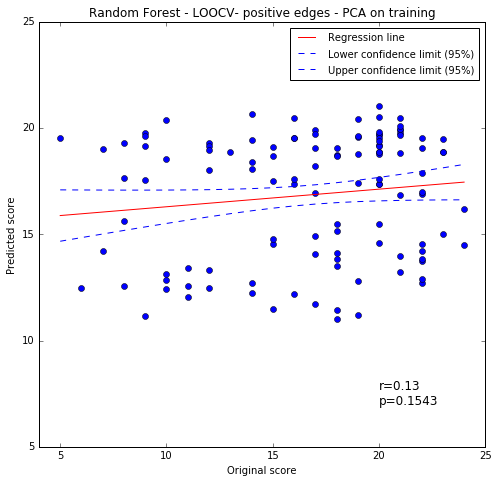

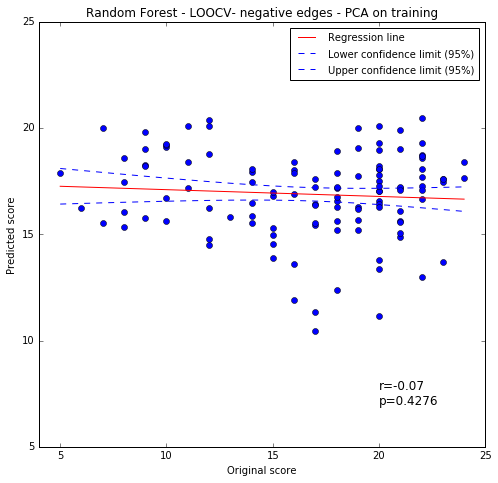

In [44]:
regression_plot(np.ravel(gF),np.ravel(preds_3),'Random Forest - LOOCV- positive edges - PCA on training') 
regression_plot(np.ravel(gF),np.ravel(preds_4),'Random Forest - LOOCV- negative edges - PCA on training') 